In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.feature_selection import SelectKBest, chi2


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)


from google.colab import files
import joblib


In [3]:
df = pd.read_csv('/content/drive/MyDrive/FDM/ncr_ride_bookings.csv')

In [4]:
df.head(5)

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23 00:00:00,12:29:38,"""CNR5884300""",Completed,"""CID1982111""",eBike,Palam Vihar,Jhilmil,6.1,45,...,no,no,no,no,no,156,69.5,5,4.2,UPI
1,2024-11-29 00:00:00,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14,...,no,no,no,NaN,Vehicle Breakdown,237,5.73,NaN,no,UPI
2,2024-08-23 00:00:00,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,no,no,no,no,no,627,NaN,4.9,4.9,Debit Card
3,2024-10-21 00:00:00,17:17:25,"""CNR8906825""",No driver found,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,NaN,28.5,...,no,no,no,no,NaN,416,34.02,4.6,5,UPI
4,2024-09-16 00:00:00,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,no,no,no,no,no,737,48.21,4.1,4.3,UPI


In [5]:
print(f"Total Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes.value_counts())

Total Rows: 150047, Columns: 21
Duplicate Rows: 6

Missing Values per Column:
 Date                                 7479
Time                                 7539
Booking ID                           7505
Booking Status                       7445
Customer ID                          7630
Vehicle Type                         7401
Pickup Location                      7480
Drop Location                        7777
Avg VTAT                             7373
Avg CTAT                             7575
Cancelled Rides by Customer          7491
Reason for cancelling by Customer    7511
Cancelled Rides by Driver            7507
Driver Cancellation Reason           7452
Incomplete Rides                     7556
Incomplete Rides Reason              7438
Booking Value                        7473
Ride Distance                        7509
Driver Ratings                       7426
Customer Rating                      7620
Payment Method                       7403
dtype: int64

Data Types:
 object    21

In [6]:
# 🧩 Feature Relevance & Leakage Check (FINAL & VERIFIED)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Unique value counts — helps detect ID columns
print("Unique value counts:")
unique_counts = df.nunique().sort_values(ascending=False)
display(unique_counts)

# Copy for safe modification
df_temp = df.copy()

# Clean & map target column robustly (handles all known formats)
df_temp["Cancelled Rides by Driver"] = (
    df["Cancelled Rides by Driver"]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"nan": np.nan, "": np.nan})
    .map(lambda x: 1 if x in ["1", "yes", "true", "cancelled", "cancelled by driver"]
         else (0 if x in ["0", "no", "false", "not cancelled"]
         else np.nan))
)

# Drop rows where target was unmapped
df_temp = df_temp.dropna(subset=["Cancelled Rides by Driver"])

# Check class balance
print("\nTarget value distribution (after cleaning):")
print(df_temp["Cancelled Rides by Driver"].value_counts(dropna=False))

# Convert numeric-like columns
numeric_like_cols = ["Booking Value", "Ride Distance", "Driver Ratings",
                     "Customer Rating", "Avg CTAT", "Avg VTAT"]

for col in numeric_like_cols:
    if col in df_temp.columns:
        df_temp[col] = (
            df_temp[col]
            .astype(str)
            .str.replace(",", "")
            .str.strip()
        )
        df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce')

# Fill missing numeric values with median for correlation
for col in numeric_like_cols:
    if df_temp[col].notna().sum() > 0:
        df_temp[col].fillna(df_temp[col].median(), inplace=True)

# Compute correlations
corrs = (
    df_temp[numeric_like_cols + ["Cancelled Rides by Driver"]]
    .corr(numeric_only=True)["Cancelled Rides by Driver"]
    .sort_values(ascending=False)
)

print("\n Correlation with target (before dropping columns):")
display(corrs)


# Leakage checks — prove certain columns leak target info
leak_cols = ['Booking Status', 'Driver Cancellation Reason',
             'Incomplete Rides', 'Incomplete Rides Reason' 'Cancelled Rides by Customer','Reason for cancelling by Customer']

for col in leak_cols:
    if col in df.columns:
        print(f"\n🔍 {col} vs Target:")
        print(df.groupby(col)['Cancelled Rides by Driver'].value_counts(normalize=True))


Unique value counts:


,0
Booking ID,141393
Customer ID,141277
Time,61796
Ride Distance,4903
Booking Value,2536
Date,365
Avg CTAT,352
Avg VTAT,182
Drop Location,176
Pickup Location,175



Target value distribution (after cleaning):
Cancelled Rides by Driver
0.0    116840
1.0     25700
Name: count, dtype: int64

 Correlation with target (before dropping columns):


,Cancelled Rides by Driver
Cancelled Rides by Driver,1.000000
Driver Ratings,0.057198
Customer Rating,-0.003627
Avg CTAT,-0.018174
Ride Distance,-0.023931
Booking Value,-0.088683
Avg VTAT,-0.119079



🔍 Booking Status vs Target:
Booking Status         Cancelled Rides by Driver
                       no                           1.000000
Cancelled by Customer  no                           1.000000
Cancelled by Driver    1                            1.000000
Completed              no                           1.000000
Incomplete             no                           1.000000
No driver found        no                           0.888889
                       1                            0.111111
Name: proportion, dtype: float64

🔍 Driver Cancellation Reason vs Target:
Driver Cancellation Reason           Cancelled Rides by Driver
Customer related issue               1                            1.0
More than permitted people in there  1                            1.0
Personal & Car related issues        1                            1.0
The customer was coughing/sick       1                            1.0
no                                   no                           1.0
Name: pr

In [7]:
df = df.drop([
    'Booking ID',
    'Customer ID',
    'Booking Status',
    'Cancelled Rides by Customer',
    'Reason for cancelling by Customer',
    'Driver Cancellation Reason',
    'Incomplete Rides',
    'Incomplete Rides Reason'
], axis=1, errors='ignore')

#rechecking
print(f"Total Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes.value_counts())

Total Rows: 150047, Columns: 13
Duplicate Rows: 9

Missing Values per Column:
 Date                         7479
Time                         7539
Vehicle Type                 7401
Pickup Location              7480
Drop Location                7777
Avg VTAT                     7373
Avg CTAT                     7575
Cancelled Rides by Driver    7507
Booking Value                7473
Ride Distance                7509
Driver Ratings               7426
Customer Rating              7620
Payment Method               7403
dtype: int64

Data Types:
 object    13
Name: count, dtype: int64


In [8]:
#rechecking
print(f"Total Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Duplicate Rows: {df.duplicated().sum()}")
print("\nMissing Values per Column:\n", df.isnull().sum())

print("\nData Types:\n", df.dtypes.value_counts())

Total Rows: 150047, Columns: 13
Duplicate Rows: 9

Missing Values per Column:
 Date                         7479
Time                         7539
Vehicle Type                 7401
Pickup Location              7480
Drop Location                7777
Avg VTAT                     7373
Avg CTAT                     7575
Cancelled Rides by Driver    7507
Booking Value                7473
Ride Distance                7509
Driver Ratings               7426
Customer Rating              7620
Payment Method               7403
dtype: int64

Data Types:
 object    13
Name: count, dtype: int64


In [9]:
num_cols = [col for col in ["Booking Value", "Ride Distance", "Driver Ratings", "Customer Rating", "Avg VTAT", "Avg CTAT"] if col in df.columns]
cat_cols = [col for col in ["Vehicle Type", "Pickup Location", "Drop Location", "Payment Method"] if col in df.columns]
#text_cols = [col for col in ["Pickup Location", "Drop Location"] if col in df.columns]
# Numeric → convert + fill with median safely
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    if df[col].notnull().sum() > 0:   # only if there are valid numbers
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(0)   # fallback if entire column is NaN

# Categorical → fill with mode safely
for col in cat_cols:
    if df[col].notnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna("Unknown")


# Drop rows with missing values for below rows
df = df.dropna(subset=["Cancelled Rides by Driver"])
df = df.dropna(subset=['Date'])
df = df.dropna(subset=['Time'])

# Re-check
print("Remaining rows:", df.shape[0])
print("Empty values \n", df.isnull().sum())


Remaining rows: 128611
Empty values 
 Date                         0
Time                         0
Vehicle Type                 0
Pickup Location              0
Drop Location                0
Avg VTAT                     0
Avg CTAT                     0
Cancelled Rides by Driver    0
Booking Value                0
Ride Distance                0
Driver Ratings               0
Customer Rating              0
Payment Method               0
dtype: int64


In [10]:
# Text preprocessing function
def clean_text(x):
    if pd.isnull(x):
        return "unknown"
    # lowercase
    x = str(x).lower()
    # remove leading/trailing spaces
    x = x.strip()
    # remove special characters except alphanumerics & space
    x = re.sub(r'[^a-z0-9\s]', '', x)
    # normalize whitespace
    x = re.sub(r'\s+', ' ', x)
    return x

# Apply to categorical columns
text_cols = ["Vehicle Type", "Pickup Location", "Drop Location", "Payment Method"]
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)


In [11]:
#Check for duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")

Duplicate Rows: 15


In [12]:
#Drop Duplicates
df = df.drop_duplicates()

In [13]:
# Function to group rare categories
def group_rare_categories(series, min_freq=1000, other_label="other"):
    value_counts = series.value_counts()
    rare_categories = value_counts[value_counts < min_freq].index
    return series.apply(lambda x: other_label if x in rare_categories else x)

# Apply to text columns after cleaning
for col in text_cols:
    if col in df.columns:
        # Clean first
        df[col] = df[col].apply(clean_text)
        # Group rare categories
        df[col] = group_rare_categories(df[col], min_freq=100, other_label="other")


In [14]:
#rechecking
print(f"Total Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print(f"Duplicate Rows: {df.duplicated().sum()}")
df.info()

Total Rows: 128596, Columns: 13
Duplicate Rows: 0
<class 'pandas.core.frame.DataFrame'>
Index: 128596 entries, 0 to 150046
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       128596 non-null  object 
 1   Time                       128596 non-null  object 
 2   Vehicle Type               128596 non-null  object 
 3   Pickup Location            128596 non-null  object 
 4   Drop Location              128596 non-null  object 
 5   Avg VTAT                   128596 non-null  float64
 6   Avg CTAT                   128596 non-null  float64
 7   Cancelled Rides by Driver  128596 non-null  object 
 8   Booking Value              128596 non-null  float64
 9   Ride Distance              128596 non-null  float64
 10  Driver Ratings             128596 non-null  float64
 11  Customer Rating            128596 non-null  float64
 12  Payment Method             128596 non-nul

In [15]:
df.head(5)

,Date,Time,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23 00:00:00,12:29:38,ebike,palam vihar,jhilmil,6.1,45.0,no,156.0,69.50,5.0,4.2,upi
1,2024-11-29 00:00:00,18:01:39,go sedan,shastri nagar,gurgaon sector 56,4.9,14.0,no,237.0,5.73,4.3,4.5,upi
2,2024-08-23 00:00:00,08:56:10,auto,khandsa,malviya nagar,13.4,25.8,no,627.0,23.75,4.9,4.9,debit card
3,2024-10-21 00:00:00,17:17:25,premier sedan,central secretariat,inderlok,8.3,28.5,no,416.0,34.02,4.6,5.0,upi
4,2024-09-16 00:00:00,22:08:00,bike,ghitorni village,khan market,5.3,19.6,no,737.0,48.21,4.1,4.3,upi


In [16]:
# Convert target column to binary (0/1)
df["Cancelled Rides by Driver"] = df["Cancelled Rides by Driver"].replace({
    "no": 0,
    "No": 0,
    "NO": 0,
    0: 0,
    "yes": 1,
    "Yes": 1,
    "YES": 1,
    "1": 1
}).astype(int)

# Check conversion
print(df["Cancelled Rides by Driver"].value_counts())


Cancelled Rides by Driver
0    105491
1     23105
Name: count, dtype: int64


In [17]:
df.head()

,Date,Time,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23 00:00:00,12:29:38,ebike,palam vihar,jhilmil,6.1,45.0,0,156.0,69.50,5.0,4.2,upi
1,2024-11-29 00:00:00,18:01:39,go sedan,shastri nagar,gurgaon sector 56,4.9,14.0,0,237.0,5.73,4.3,4.5,upi
2,2024-08-23 00:00:00,08:56:10,auto,khandsa,malviya nagar,13.4,25.8,0,627.0,23.75,4.9,4.9,debit card
3,2024-10-21 00:00:00,17:17:25,premier sedan,central secretariat,inderlok,8.3,28.5,0,416.0,34.02,4.6,5.0,upi
4,2024-09-16 00:00:00,22:08:00,bike,ghitorni village,khan market,5.3,19.6,0,737.0,48.21,4.1,4.3,upi


In [18]:

# Weekend Flag (is_weekend)
# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['Date'].dt.dayofweek

# Create 'is_weekend' feature (1 for Saturday or Sunday, 0 otherwise)
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Convert Time column to datetime (just the time part)
df["hour_of_day"] = pd.to_datetime(df["Time"], errors="coerce").dt.hour

# Peak hour flag: 7–10 AM or 17–21 PM = 1, else 0
df["peak_hour"] = df["hour_of_day"].apply(lambda x: 1 if (7 <= x <= 10) or (17 <= x <= 21) else 0)

# Drop raw Date and Time (not needed anymore)
df = df.drop(columns=["Date", "Time"])

# Check new columns
print(df[["day_of_week", "hour_of_day", "peak_hour", "is_weekend"]].head())



   day_of_week  hour_of_day  peak_hour  is_weekend
0            5           12          0           1
1            4           18          1           0
2            4            8          1           0
3            0           17          1           0
4            0           22          0           0


In [19]:
df.head(5)

,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,day_of_week,is_weekend,hour_of_day,peak_hour
0,ebike,palam vihar,jhilmil,6.1,45.0,0,156.0,69.50,5.0,4.2,upi,5,1,12,0
1,go sedan,shastri nagar,gurgaon sector 56,4.9,14.0,0,237.0,5.73,4.3,4.5,upi,4,0,18,1
2,auto,khandsa,malviya nagar,13.4,25.8,0,627.0,23.75,4.9,4.9,debit card,4,0,8,1
3,premier sedan,central secretariat,inderlok,8.3,28.5,0,416.0,34.02,4.6,5.0,upi,0,0,17,1
4,bike,ghitorni village,khan market,5.3,19.6,0,737.0,48.21,4.1,4.3,upi,0,0,22,0


In [20]:
def cap_outliers(series, factor=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    return np.where(series < lower, lower, np.where(series > upper, upper, series))


for col in num_cols:
    df[col] = cap_outliers(df[col])


In [21]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outliers")

Booking Value: 0 outliers
Ride Distance: 0 outliers
Driver Ratings: 0 outliers
Customer Rating: 0 outliers
Avg VTAT: 0 outliers
Avg CTAT: 0 outliers


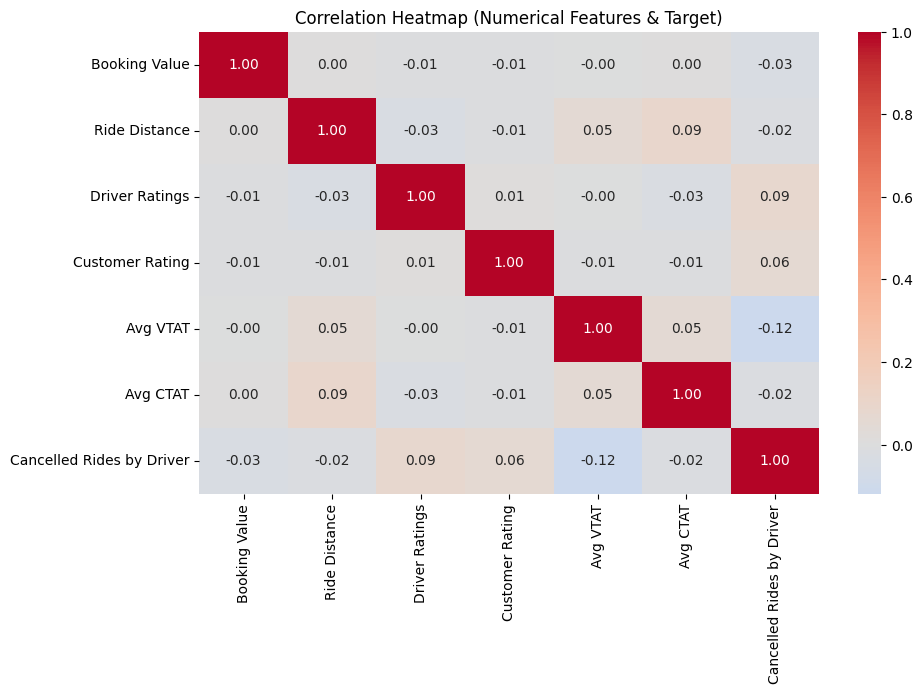

Correlation with target (Cancelled Rides by Driver):
 Cancelled Rides by Driver    1.000000
Driver Ratings               0.085570
Customer Rating              0.057456
Avg CTAT                    -0.016621
Ride Distance               -0.021024
Booking Value               -0.034757
Avg VTAT                    -0.119318
Name: Cancelled Rides by Driver, dtype: float64


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for numerical features + target
corr_matrix = df[num_cols + ["Cancelled Rides by Driver"]].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features & Target)")
plt.show()

# Correlation values of each feature with target
target_corr = corr_matrix["Cancelled Rides by Driver"].sort_values(ascending=False)
print("Correlation with target (Cancelled Rides by Driver):\n", target_corr)


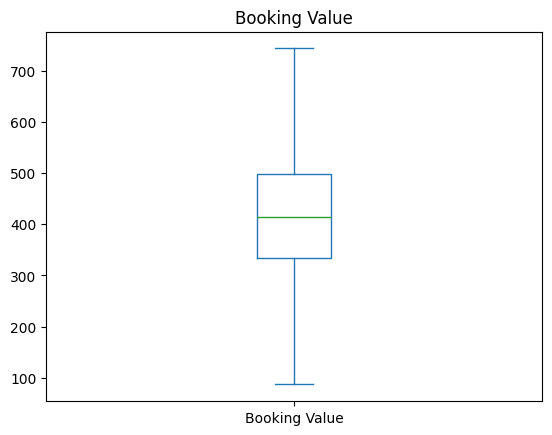

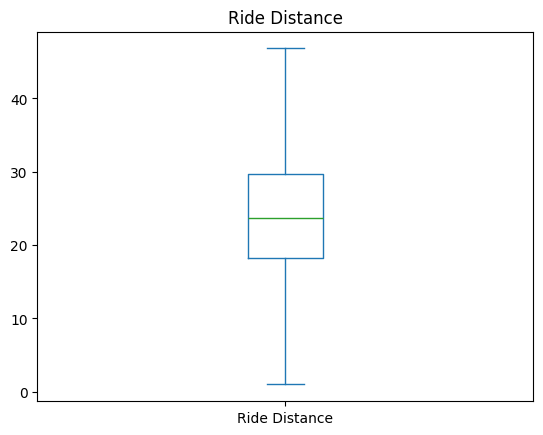

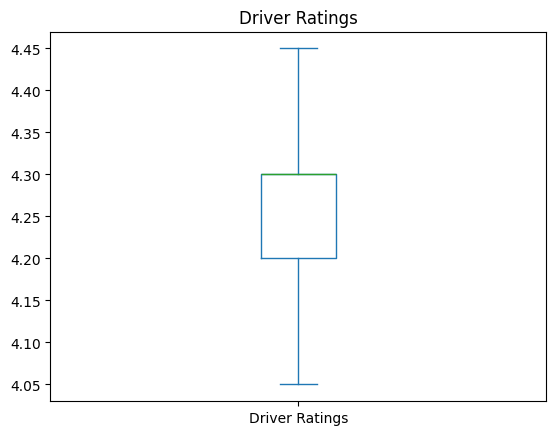

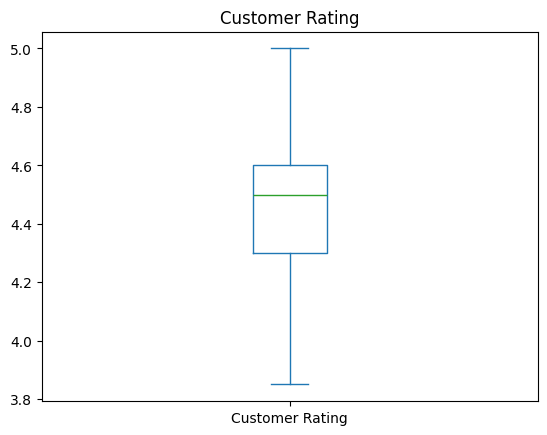

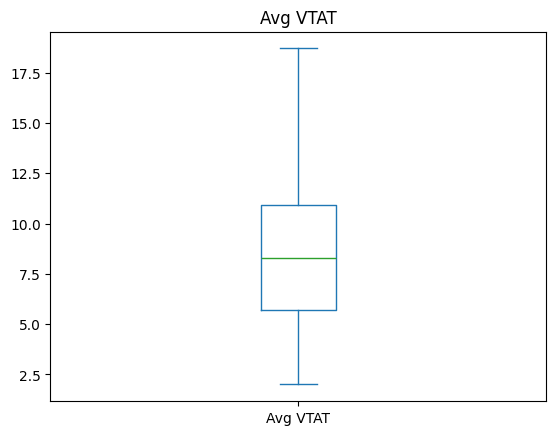

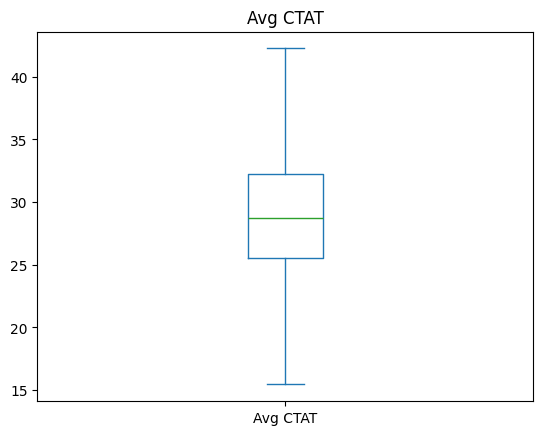

In [23]:
for col in num_cols:
    plt.figure()
    df[col].plot(kind="box", title=col)
    plt.show()

In [24]:
!pip install category_encoders

In [25]:
X = df.drop("Cancelled Rides by Driver", axis =1)
y = df["Cancelled Rides by Driver"]


In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
from category_encoders import TargetEncoder

# Define which categorical columns use which encoder
target_encode_cols = ["Pickup Location", "Drop Location"]
onehot_encode_cols = ["Vehicle Type", "Payment Method"]

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), num_cols),
        ("target_enc", TargetEncoder(cols=target_encode_cols), target_encode_cols),
        ("onehot", OneHotEncoder(handle_unknown="ignore"), onehot_encode_cols)
    ]
)

# Feature selector
chi2_selector = SelectKBest(chi2, k='all')

In [28]:
ratio_of_minority_class_to_majority_class = len(y_train[y_train == 0]) / len(y_train[y_train == 1])


In [29]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, min_samples_leaf=20, random_state=42, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight="balanced",
        random_state=42
    ),
    "Gradient Boosting": xgb.XGBClassifier(
          n_estimators=200,
          learning_rate=0.05,
          max_depth=5,
          subsample=0.8,
          random_state=42,
          scale_pos_weight=ratio_of_minority_class_to_majority_class

    )
}



✅ Transformed feature count: 22
💾 Saved model: Logistic_Regression_pipeline.pkl
💾 Saved model: Decision_Tree_pipeline.pkl
💾 Saved model: Random_Forest_pipeline.pkl
💾 Saved model: Gradient_Boosting_pipeline.pkl

===== 🧩 Model Results =====


,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
Logistic Regression,0.855,0.552,1.000,0.712,0.934,0.671
Decision Tree,0.950,0.806,0.951,0.873,0.982,0.882
Random Forest,0.900,0.641,1.000,0.781,0.981,0.879
Gradient Boosting,0.934,0.743,0.968,0.841,0.982,0.902


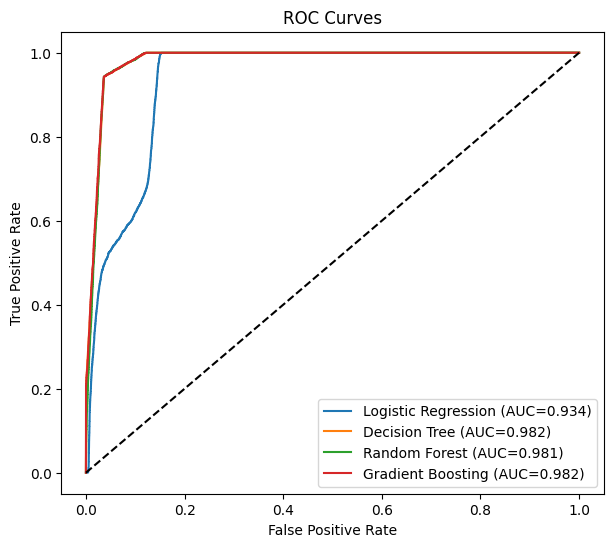

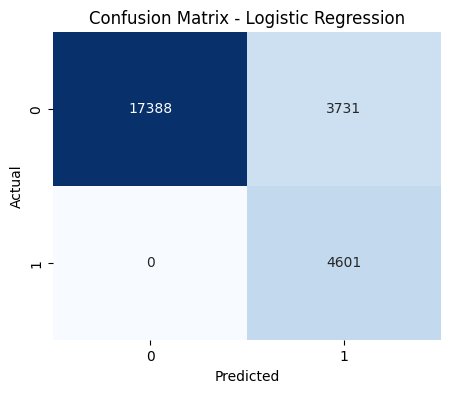

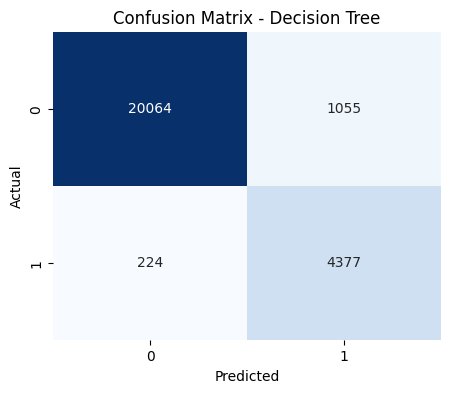

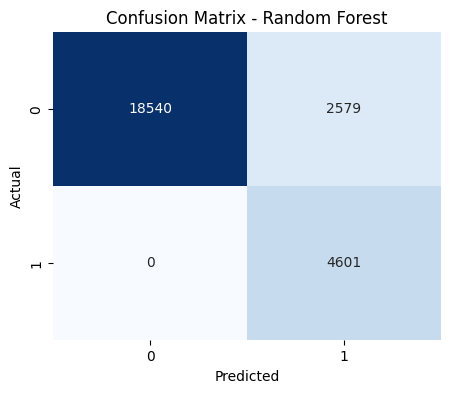

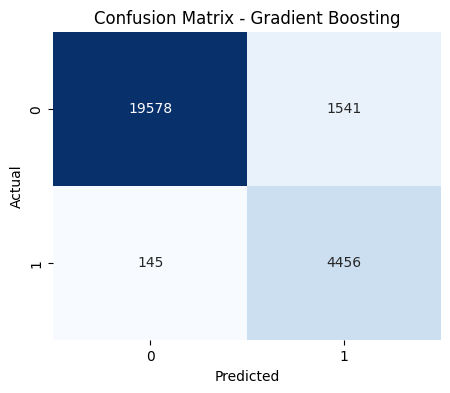

✅ Training complete — All 4 pipeline models have been saved successfully.


In [30]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

# --- Initialize results storage ---
results_summary = {}
conf_matrices = {}
roc_curves = {}
pr_curves = {}

# --- Fit preprocessor once to verify encoded feature count ---
preprocessor.fit(X_train, y_train)
print(f"✅ Transformed feature count: {preprocessor.transform(X_train).shape[1]}")

# --- Training Loop ---
for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", chi2_selector),
        ("classifier", model)
    ])

    clf.fit(X_train, y_train)

    # Predictions
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    y_pred = (y_proba >= 0.4).astype(int) if y_proba is not None else clf.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1 = report["1"]["f1-score"]
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    ap = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan

    results_summary[name] = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "ROC-AUC": auc,
        "PR-AUC": ap
    }

    conf_matrices[name] = confusion_matrix(y_test, y_pred)

    # Curves
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves[name] = (fpr, tpr)
        prec, rec, _ = precision_recall_curve(y_test, y_proba)
        pr_curves[name] = (rec, prec)

    # --- Save every pipeline model ---
    model_path = f"{name.replace(' ', '_')}_pipeline.pkl"
    joblib.dump(clf, model_path)
    print(f"💾 Saved model: {model_path}")

# --- Summary Table ---
results_df = pd.DataFrame(results_summary).T.round(3)
print("\n===== 🧩 Model Results =====")
display(results_df)

# --- ROC Curves ---
plt.figure(figsize=(7,6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={results_summary[name]['ROC-AUC']:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# --- Confusion Matrices ---
for name, cm in conf_matrices.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

print("✅ Training complete — All 4 pipeline models have been saved successfully.")


In [31]:

files.download("Logistic_Regression_pipeline.pkl")
files.download("Decision_Tree_pipeline.pkl")
files.download("Random_Forest_pipeline.pkl")
files.download("Gradient_Boosting_pipeline.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

===== Results Summary (with ranking) =====


,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC,Accuracy_Rank,Precision_Rank,Recall_Rank,F1_Rank,ROC-AUC_Rank,PR-AUC_Rank
Logistic Regression,0.854938,0.552208,1.000000,0.711513,0.933645,0.670504,4.0,4.0,1.5,4.0,4.0,4.0
Decision Tree,0.950272,0.805781,0.951315,0.872521,0.981736,0.882041,1.0,1.0,4.0,1.0,2.0,2.0
Random Forest,0.899728,0.640808,1.000000,0.781088,0.980704,0.879476,3.0,3.0,1.5,3.0,3.0,3.0
Gradient Boosting,0.934448,0.743038,0.968485,0.840913,0.982325,0.901789,2.0,2.0,3.0,2.0,1.0,1.0



===== Best Models per Metric =====
Accuracy: Decision Tree (0.950)
Precision: Decision Tree (0.806)
Recall: Logistic Regression (1.000)
F1: Decision Tree (0.873)
ROC-AUC: Gradient Boosting (0.982)
PR-AUC: Gradient Boosting (0.902)


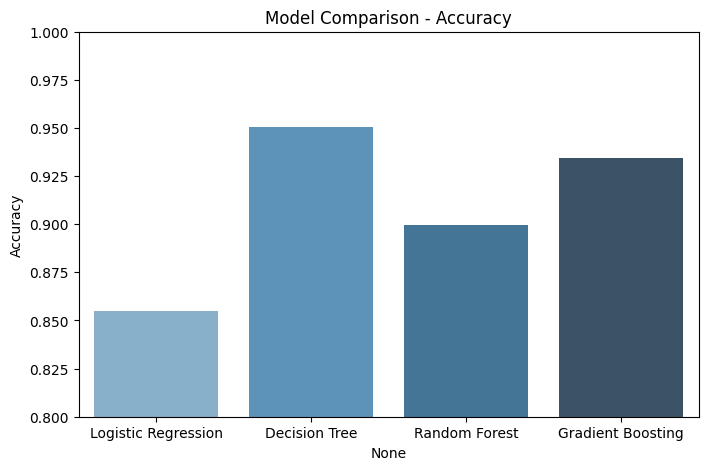

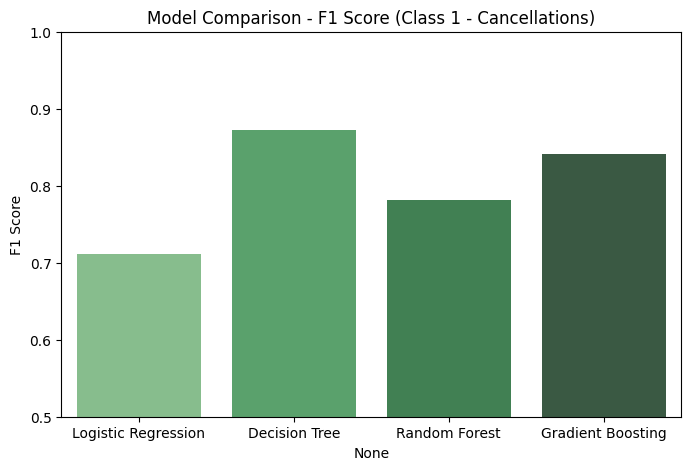

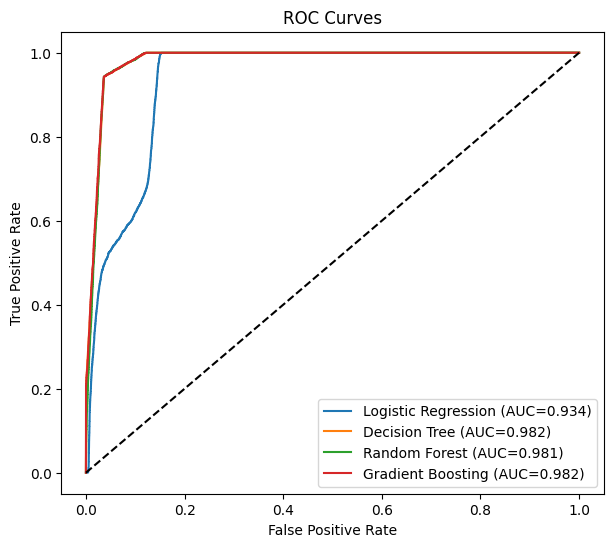

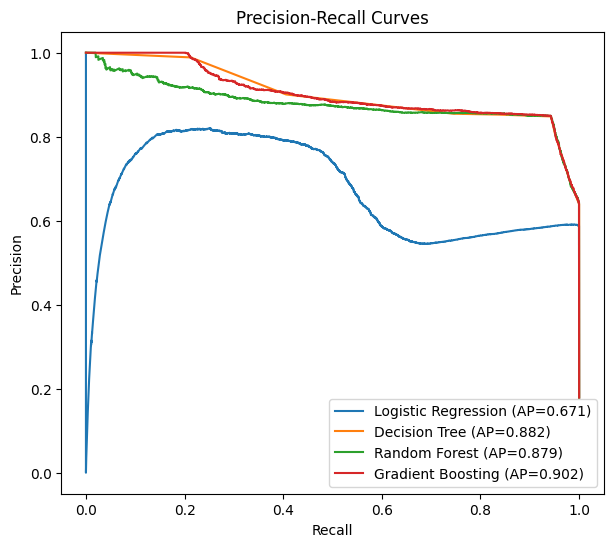

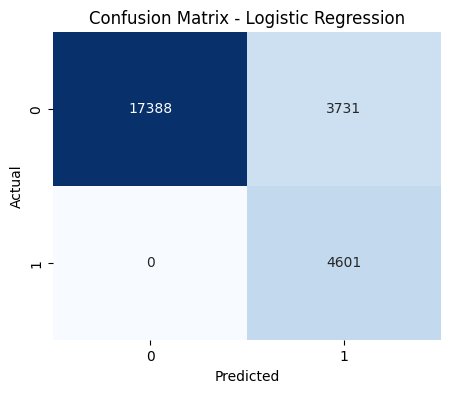

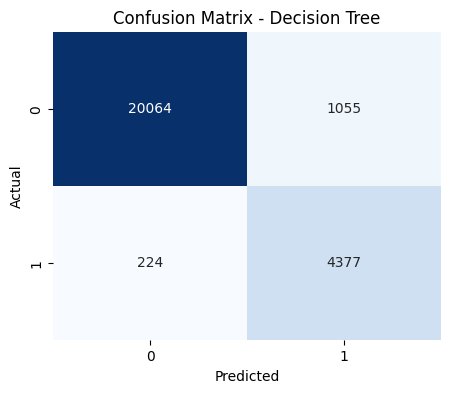

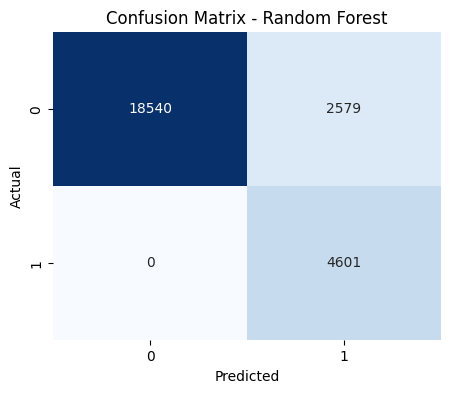

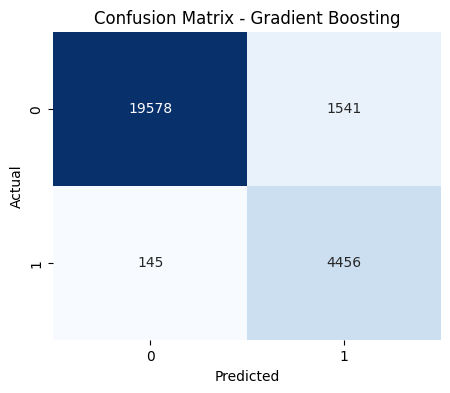

In [32]:
# 2. Results Table
results_df = pd.DataFrame(results_summary).T

# Add rank columns (lower rank = better)
ranked_df = results_df.copy()
for col in results_df.columns:
    ranked_df[col+"_Rank"] = results_df[col].rank(ascending=False)

# Highlight best model for each metric
best_models = {}
for col in results_df.columns:
    best_models[col] = results_df[col].idxmax()

print("===== Results Summary (with ranking) =====")
display(ranked_df)

print("\n===== Best Models per Metric =====")
for metric, model in best_models.items():
    print(f"{metric}: {model} ({results_df.loc[model, metric]:.3f})")


# 3. Accuracy & F1 Bar Charts

plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["Accuracy"], palette="Blues_d")
plt.title("Model Comparison - Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y=results_df["F1"], palette="Greens_d")
plt.title("Model Comparison - F1 Score (Class 1 - Cancellations)")
plt.ylabel("F1 Score")
plt.ylim(0.5, 1.0)
plt.show()


# 4. ROC Curves

plt.figure(figsize=(7,6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={results_summary[name]['ROC-AUC']:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

# 5. Precision-Recall Curves

plt.figure(figsize=(7,6))
for name, (rec, prec) in pr_curves.items():
    plt.plot(rec, prec, label=f"{name} (AP={results_summary[name]['PR-AUC']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


# 6. Confusion Matrices (Optional display)

for name, cm in conf_matrices.items():
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [33]:
# --- Load the trained Gradient Boosting pipeline ---
loaded_model = joblib.load("Gradient_Boosting_pipeline.pkl")
print("✅ Gradient Boosting pipeline loaded successfully!")

# --- Example user input ---
user_input = {
    "Booking Value": 414.0,
    "Ride Distance": 23.75,
    "Driver Ratings": 4.30,
    "Vehicle Type": "auto",                 # Example from dataset
    "Pickup Location": "noida sector 18",
    "Drop Location": "badshahpur",
    "Payment Method": "no",
    "day_of_week": 1,
    "is_weekend": 0,
    "hour_of_day": 21,
    "peak_hour": 1,
    "Avg VTAT": 6.5,
    "Avg CTAT": 28.70,
    "Customer Rating": 4.5
}

# --- Convert input to DataFrame ---
user_df = pd.DataFrame([user_input])

# --- Make prediction ---
prob = loaded_model.predict_proba(user_df)[0][1]   # Probability of "Cancelled" (1)
threshold = 0.4
prediction = (prob >= threshold).astype(int)

# --- Compute confidence level ---
confidence = prob if prediction == 1 else (1 - prob)
confidence_percent = confidence * 100

# --- Categorize confidence ---
if confidence_percent >= 85:
    conf_label = "High confidence"
elif confidence_percent >= 65:
    conf_label = "Moderate confidence"
else:
    conf_label = "Low confidence"

# --- Display result ---
print("=====================================")
if prediction == 1:
    print(f"❌ The ride is LIKELY CANCELLED")
    print(f"🔹 Probability of cancellation: {prob:.2f}")
else:
    print(f"✅ The ride is LIKELY NOT CANCELLED")
    print(f"🔹 Probability of not cancellation: {1 - prob:.2f}")

print(f"🧠 Model confidence: {confidence_percent:.1f}% ({conf_label})")
print(f"Decision: {'Cancelled' if prediction == 1 else 'Not Cancelled'}")
print("=====================================")


✅ Gradient Boosting pipeline loaded successfully!
❌ The ride is LIKELY CANCELLED
🔹 Probability of cancellation: 0.95
🧠 Model confidence: 94.8% (High confidence)
Decision: Cancelled


In [34]:
X_val

,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,day_of_week,is_weekend,hour_of_day,peak_hour
55042,auto,udyog vihar phase 4,pulbangash,6.5,28.70,414.0,23.75,4.30,4.5,no,1,0,10,1
87394,go sedan,manesar,badshahpur,9.0,28.70,414.0,23.75,4.30,4.5,no,5,1,18,1
35537,auto,connaught place,rohini east,9.0,34.20,140.0,5.42,4.45,4.6,credit card,0,0,9,1
57772,auto,khan market,iffco chowk,3.4,28.70,414.0,23.75,4.30,4.5,no,0,0,16,0
45803,go sedan,kanhaiya nagar,green park,6.6,28.70,414.0,23.75,4.30,4.5,no,6,1,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65219,auto,keshav puram,rohini west,4.3,42.25,570.0,20.19,4.45,4.4,upi,2,0,10,1
104202,go sedan,rohini,,4.5,28.70,414.0,23.75,4.30,4.5,no,6,1,19,1
5410,go sedan,cyber hub,karkarduma,9.1,25.40,408.0,45.14,4.45,4.1,uber wallet,0,0,3,0
33487,bike,noida sector 18,,4.2,28.70,414.0,23.75,4.30,4.5,no,1,0,21,1


In [35]:
y_val

,Cancelled Rides by Driver
55042,0
87394,1
35537,0
57772,1
45803,1
...,...
65219,0
104202,1
5410,0
33487,1
